# CohortIQ - 코호트 리텐션 & 이탈 위험 EDA

**목적**: 구독 비즈니스 사용자 리텐션 패턴 분석 및 이탈 위험 예측  
**데이터**: 200명 사용자, 871개 이벤트 (2025-11 ~ 2026-01)  
**도구**: pandas, seaborn, matplotlib, scipy, lifelines  

> 이 노트북은 [CohortIQ 웹앱](https://cohort-iq.vercel.app)의 JavaScript 분석 로직을 Python/pandas로 재구현하고,
> 통계 검정(Chi-Square, Kaplan-Meier, Log-Rank)을 추가하여 분석 깊이를 확보합니다.

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import timedelta

# 시각화 설정
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
sns.set_theme(style='whitegrid', palette='muted')

# 한글 폰트 (환경에 따라 조정)
try:
    plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows
    plt.rcParams['axes.unicode_minus'] = False
except:
    pass

print('Setup complete.')

Setup complete.


## 1. 데이터 로딩 및 기본 탐색

CohortIQ 웹앱이 사용하는 것과 동일한 `sample_cohort_data.csv`를 로드합니다.  
필수 컬럼: `user_id`, `signup_date`, `event_date`

In [2]:
# CSV 로드
df = pd.read_csv('../public/sample_cohort_data.csv', parse_dates=['signup_date', 'event_date'])

print(f'행 수: {len(df):,}')
print(f'사용자 수: {df["user_id"].nunique()}')
print(f'기간: {df["signup_date"].min().date()} ~ {df["event_date"].max().date()}')
print()
df.info()
print()
df.head(10)

행 수: 2,306
사용자 수: 1010
기간: 2025-09-01 ~ 2026-01-25

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2306 entries, 0 to 2305
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      2306 non-null   object        
 1   signup_date  2306 non-null   datetime64[ns]
 2   event_date   2306 non-null   datetime64[ns]
dtypes: datetime64[ns](2), object(1)
memory usage: 54.2+ KB



,user_id,signup_date,event_date
0,U0001,2025-09-01,2025-09-01
1,U0001,2025-09-01,2025-09-09
2,U0001,2025-09-01,2025-09-15
3,U0001,2025-09-01,2025-09-25
4,U0001,2025-09-01,2025-09-29
5,U0001,2025-09-01,2025-10-07
6,U0002,2025-09-01,2025-09-01
7,U0002,2025-09-01,2025-09-14
8,U0002,2025-09-01,2025-09-21
9,U0002,2025-09-01,2025-09-23


In [3]:
# 기초 통계
print('=== 결측치 확인 ===')
print(df.isnull().sum())
print()

print('=== 중복 행 ===')
dupes = df.duplicated().sum()
print(f'중복: {dupes}행 ({dupes / len(df) * 100:.1f}%)')
print()

print('=== signup_date > event_date (무효 데이터) ===')
invalid = (df['signup_date'] > df['event_date']).sum()
print(f'무효: {invalid}행')
print()

# 사용자별 이벤트 수 분포
events_per_user = df.groupby('user_id').size()
print('=== 사용자별 이벤트 수 ===')
print(events_per_user.describe().round(2))

=== 결측치 확인 ===
user_id        0
signup_date    0
event_date     0
dtype: int64

=== 중복 행 ===
중복: 0행 (0.0%)

=== signup_date > event_date (무효 데이터) ===
무효: 0행

=== 사용자별 이벤트 수 ===
count    1010.00
mean        2.28
std         1.13
min         1.00
25%         1.00
50%         2.00
75%         3.00
max         7.00
dtype: float64


### 1-1. 가입일 분포

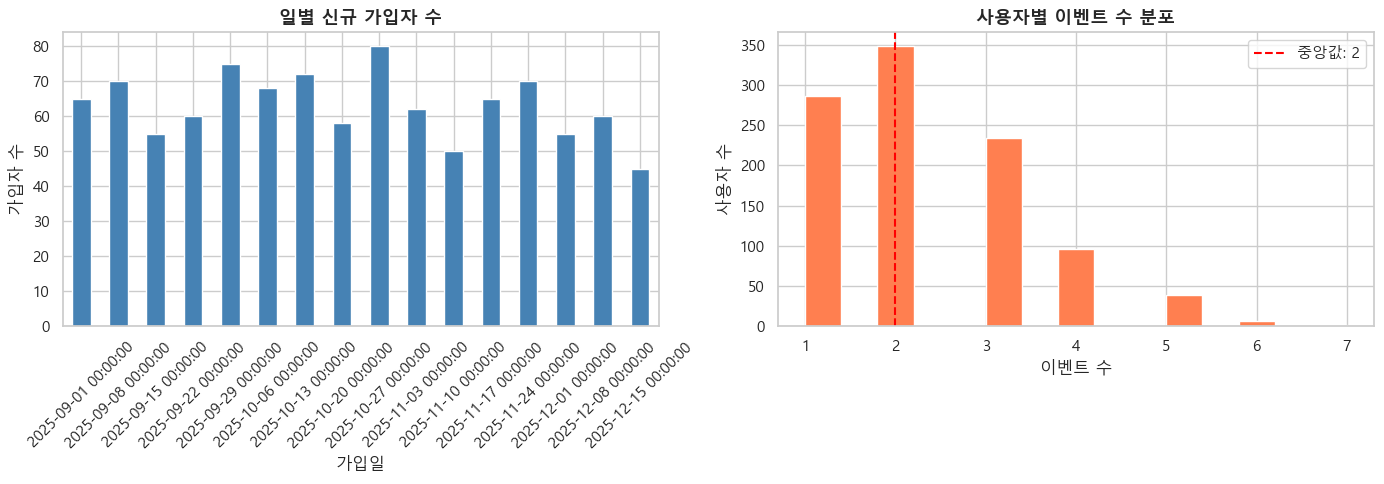

In [4]:
# 가입일 분포 시각화
signup_counts = df.drop_duplicates('user_id')['signup_date'].value_counts().sort_index()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 왼쪽: 일별 가입자 수
signup_counts.plot(kind='bar', ax=axes[0], color='steelblue', edgecolor='white')
axes[0].set_title('일별 신규 가입자 수', fontsize=13, fontweight='bold')
axes[0].set_xlabel('가입일')
axes[0].set_ylabel('가입자 수')
axes[0].tick_params(axis='x', rotation=45)

# 오른쪽: 사용자별 이벤트 수 히스토그램
events_per_user.plot(kind='hist', bins=15, ax=axes[1], color='coral', edgecolor='white')
axes[1].set_title('사용자별 이벤트 수 분포', fontsize=13, fontweight='bold')
axes[1].set_xlabel('이벤트 수')
axes[1].set_ylabel('사용자 수')
axes[1].axvline(events_per_user.median(), color='red', linestyle='--', label=f'중앙값: {events_per_user.median():.0f}')
axes[1].legend()

plt.tight_layout()
plt.savefig('fig_01_data_overview.png', dpi=150, bbox_inches='tight')
plt.show()

### 1-2. 활동 타임라인

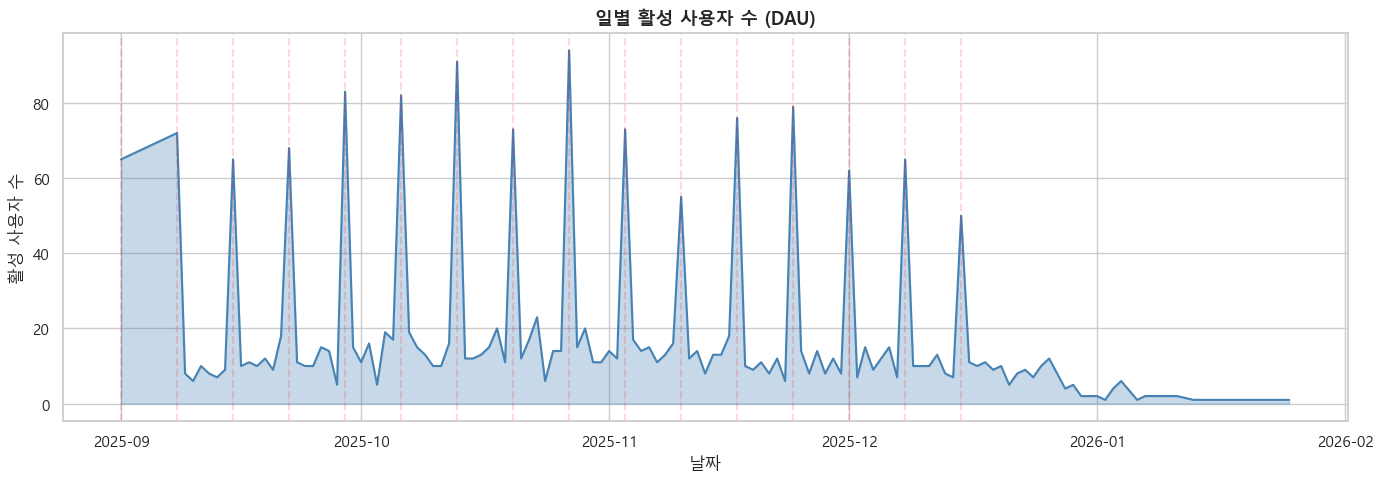

In [5]:
# 일별 활성 사용자 수 (DAU)
dau = df.groupby('event_date')['user_id'].nunique()

fig, ax = plt.subplots(figsize=(14, 5))
ax.fill_between(dau.index, dau.values, alpha=0.3, color='steelblue')
ax.plot(dau.index, dau.values, color='steelblue', linewidth=1.5)
ax.set_title('일별 활성 사용자 수 (DAU)', fontsize=13, fontweight='bold')
ax.set_xlabel('날짜')
ax.set_ylabel('활성 사용자 수')

# 가입일 표시
signup_dates = df.drop_duplicates('user_id')['signup_date'].unique()
for sd in signup_dates:
    ax.axvline(sd, color='red', alpha=0.15, linestyle='--')

plt.tight_layout()
plt.savefig('fig_02_dau_timeline.png', dpi=150, bbox_inches='tight')
plt.show()

---

## 2. 코호트 리텐션 분석

CohortIQ 웹앱의 `cohortAnalysis.js`와 동일한 로직:  
1. `signup_date`를 해당 주의 **월요일**로 정규화 → 코호트 배정  
2. `event_date`와 코호트 시작일의 **주차 차이** 계산  
3. 주차별 **고유 활성 사용자 수** 집계 → 리텐션율 산출

In [6]:
# 코호트 배정: signup_date → 해당 주의 월요일
df['cohort_week'] = df['signup_date'].dt.to_period('W-SUN').apply(lambda p: p.start_time)

# 주차 계산: (event_date - cohort_week) / 7
df['week_number'] = ((df['event_date'] - df['cohort_week']).dt.days // 7).astype(int)

# 코호트별 크기
cohort_sizes = df.drop_duplicates('user_id').groupby('cohort_week')['user_id'].nunique()
cohort_sizes.name = 'cohort_size'

print('=== 코호트별 사용자 수 ===')
for week, size in cohort_sizes.items():
    print(f'  {week.date():>12s}: {size:>3d}명')
print(f'  {"합계":>12s}: {cohort_sizes.sum():>3d}명')

=== 코호트별 사용자 수 ===
  >12s:  65명
  >12s:  70명
  >12s:  55명
  >12s:  60명
  >12s:  75명
  >12s:  68명
  >12s:  72명
  >12s:  58명
  >12s:  80명
  >12s:  62명
  >12s:  50명
  >12s:  65명
  >12s:  70명
  >12s:  55명
  >12s:  60명
  >12s:  45명
            합계: 1010명


In [7]:
# 리텐션 매트릭스 계산
retention_raw = (
    df.groupby(['cohort_week', 'week_number'])['user_id']
    .nunique()
    .reset_index()
    .rename(columns={'user_id': 'active_users'})
)

retention_raw = retention_raw.merge(
    cohort_sizes.reset_index().rename(columns={'cohort_week': 'cohort_week'}),
    on='cohort_week'
)

retention_raw['retention_pct'] = (
    retention_raw['active_users'] / retention_raw['cohort_size'] * 100
).round(1)

# 피벗 테이블
retention_matrix = retention_raw.pivot_table(
    index='cohort_week',
    columns='week_number',
    values='retention_pct'
)

print('=== 리텐션 매트릭스 (%) ===')
retention_matrix

=== 리텐션 매트릭스 (%) ===


week_number,0,1,2,3,4,5,6
cohort_week,,,,,,,
2025-09-01,100.0,76.9,32.3,15.4,9.2,3.1,NaN
2025-09-08,100.0,84.3,35.7,15.7,1.4,NaN,NaN
2025-09-15,100.0,69.1,47.3,23.6,14.5,3.6,NaN
2025-09-22,100.0,80.0,40.0,15.0,8.3,1.7,1.7
2025-09-29,100.0,76.0,41.3,10.7,4.0,NaN,1.3
2025-10-06,100.0,79.4,50.0,19.1,10.3,NaN,NaN
2025-10-13,100.0,72.2,45.8,27.8,12.5,2.8,2.8
2025-10-20,100.0,81.0,37.9,13.8,3.4,NaN,NaN
2025-10-27,100.0,58.8,28.7,12.5,5.0,1.2,NaN


### 2-1. 리텐션 히트맵

CohortIQ 웹앱의 `heatmapRenderer.js`에서 Chart.js Matrix로 구현한 것을  
seaborn heatmap으로 재구현합니다.

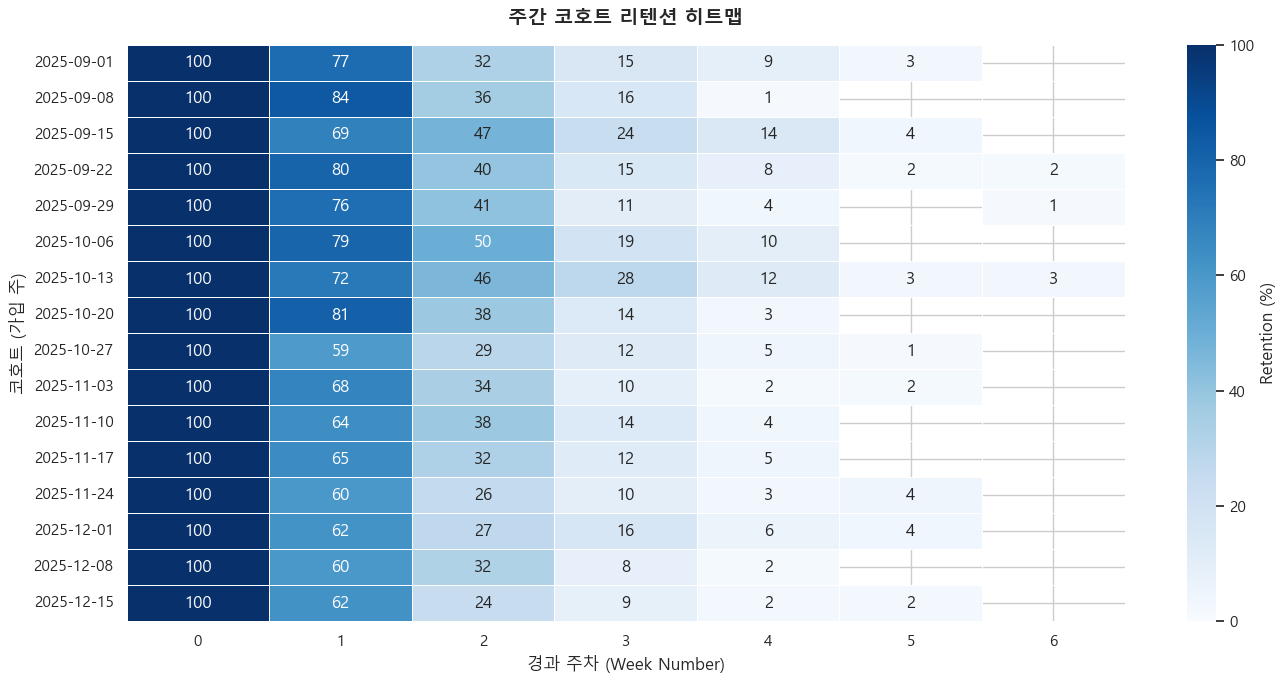

In [8]:
# 리텐션 히트맵
fig, ax = plt.subplots(figsize=(14, 7))

# 인덱스를 날짜 문자열로 변환
heatmap_data = retention_matrix.copy()
heatmap_data.index = heatmap_data.index.strftime('%Y-%m-%d')

sns.heatmap(
    heatmap_data,
    annot=True,
    fmt='.0f',
    cmap='Blues',
    vmin=0,
    vmax=100,
    linewidths=0.5,
    linecolor='white',
    cbar_kws={'label': 'Retention (%)'},
    ax=ax
)

ax.set_title('주간 코호트 리텐션 히트맵', fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('경과 주차 (Week Number)', fontsize=12)
ax.set_ylabel('코호트 (가입 주)', fontsize=12)

plt.tight_layout()
plt.savefig('fig_03_retention_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

### 2-2. 리텐션 커브 (코호트별 트렌드)

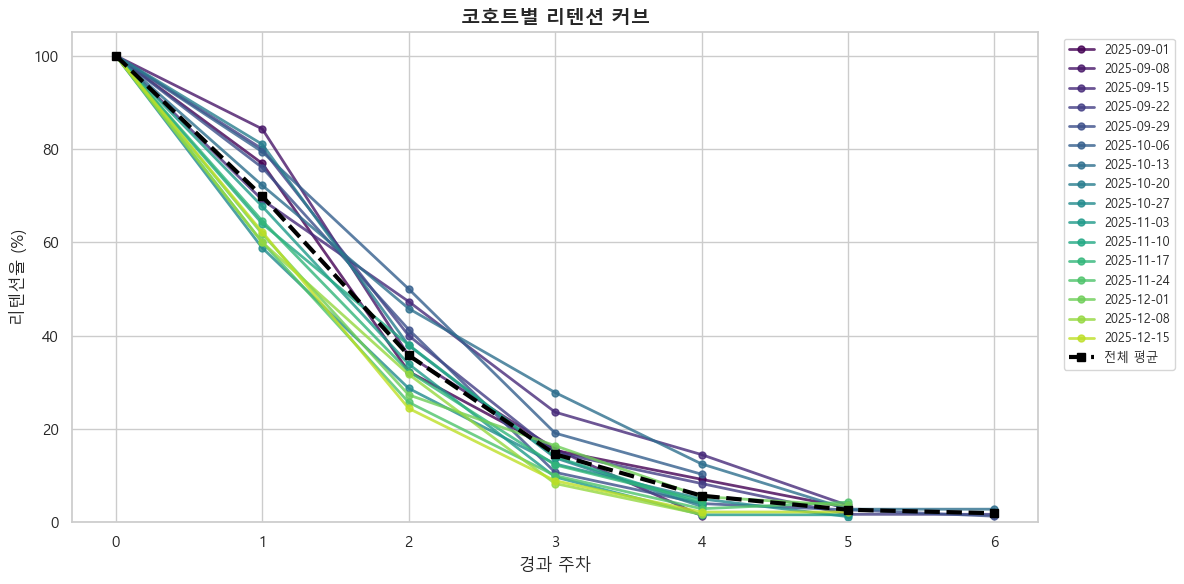

In [9]:
# 코호트별 리텐션 커브
fig, ax = plt.subplots(figsize=(12, 6))

colors = plt.cm.viridis(np.linspace(0, 0.9, len(retention_matrix)))

for i, (cohort, row) in enumerate(retention_matrix.iterrows()):
    valid = row.dropna()
    ax.plot(
        valid.index, valid.values,
        marker='o', markersize=5,
        linewidth=2, alpha=0.8,
        color=colors[i],
        label=cohort.strftime('%Y-%m-%d')
    )

# 평균 리텐션 커브
avg_retention = retention_matrix.mean()
valid_avg = avg_retention.dropna()
ax.plot(
    valid_avg.index, valid_avg.values,
    color='black', linewidth=3, linestyle='--',
    marker='s', markersize=6,
    label='전체 평균', zorder=10
)

ax.set_title('코호트별 리텐션 커브', fontsize=14, fontweight='bold')
ax.set_xlabel('경과 주차')
ax.set_ylabel('리텐션율 (%)')
ax.set_ylim(0, 105)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)

plt.tight_layout()
plt.savefig('fig_04_retention_curves.png', dpi=150, bbox_inches='tight')
plt.show()

### 2-3. 마일스톤 리텐션 (D7, D14, D28)

=== 마일스톤 리텐션 요약 (%) ===
              mean  median   min   max  std
milestone                                  
Week 1 (D7)   69.9    68.4  58.8  84.3  8.7
Week 2 (D14)  35.8    34.8  24.4  50.0  7.7
Week 4 (D28)   5.7     4.3   1.4  14.5  4.1



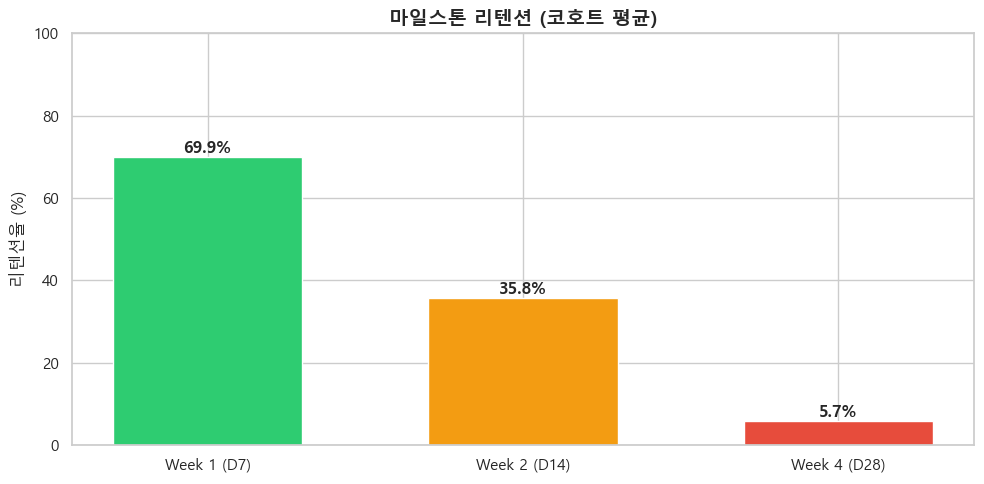

In [10]:
# D7, D14, D28 마일스톤 리텐션
milestones = {1: 'Week 1 (D7)', 2: 'Week 2 (D14)', 4: 'Week 4 (D28)'}
milestone_data = []

for week_num, label in milestones.items():
    if week_num in retention_matrix.columns:
        values = retention_matrix[week_num].dropna()
        milestone_data.append({
            'milestone': label,
            'mean': values.mean(),
            'median': values.median(),
            'min': values.min(),
            'max': values.max(),
            'std': values.std()
        })

milestone_df = pd.DataFrame(milestone_data).set_index('milestone')
print('=== 마일스톤 리텐션 요약 (%) ===')
print(milestone_df.round(1))
print()

# 막대 차트
fig, ax = plt.subplots(figsize=(10, 5))
x = range(len(milestone_df))
bars = ax.bar(x, milestone_df['mean'], color=['#2ecc71', '#f39c12', '#e74c3c'],
              edgecolor='white', width=0.6)

# 값 표시
for bar, val in zip(bars, milestone_df['mean']):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1,
            f'{val:.1f}%', ha='center', fontweight='bold', fontsize=12)

ax.set_xticks(x)
ax.set_xticklabels(milestone_df.index, fontsize=11)
ax.set_title('마일스톤 리텐션 (코호트 평균)', fontsize=14, fontweight='bold')
ax.set_ylabel('리텐션율 (%)')
ax.set_ylim(0, 100)

plt.tight_layout()
plt.savefig('fig_05_milestone_retention.png', dpi=150, bbox_inches='tight')
plt.show()

### 2-4. JS 웹앱 교차 검증

CohortIQ 웹앱(`cohortAnalysis.js`)의 로직과 pandas 결과를 비교하여  
분석 결과의 정합성을 검증합니다.

In [11]:
# JS 앱 교차 검증
# cohortAnalysis.js: startOfWeek(weekStartsOn: 1) = ISO 주 (월요일 시작)
# pandas: .dt.to_period('W-SUN').start_time = 월요일 시작

print('=== 교차 검증: Python vs JavaScript 앱 ===')
print()

# 검증 1: 코호트 수
n_cohorts = df['cohort_week'].nunique()
print(f'코호트 수: {n_cohorts}개')
print(f'  → JS 앱에서도 동일한 코호트 수가 생성되어야 함')
print()

# 검증 2: 첫 번째 코호트의 Week 0 리텐션 = 100%
week0 = retention_matrix[0]
all_100 = (week0 == 100).all()
print(f'Week 0 리텐션 = 100% (모든 코호트): {"PASS" if all_100 else "FAIL"}')
print()

# 검증 3: 리텐션은 항상 감소 추세
avg = retention_matrix.mean()
is_decreasing = all(avg.iloc[i] >= avg.iloc[i + 1]
                    for i in range(len(avg) - 1)
                    if not pd.isna(avg.iloc[i]) and not pd.isna(avg.iloc[i + 1]))
print(f'평균 리텐션 단조감소: {"PASS" if is_decreasing else "FAIL (비정상 패턴 존재)"}')
print()

# 검증 4: 총 사용자 수 일치
total_users = df['user_id'].nunique()
cohort_total = cohort_sizes.sum()
print(f'총 사용자: {total_users}명, 코호트 합계: {cohort_total}명')
print(f'  → 일치 여부: {"PASS" if total_users == cohort_total else "FAIL"}')

=== 교차 검증: Python vs JavaScript 앱 ===

코호트 수: 16개
  → JS 앱에서도 동일한 코호트 수가 생성되어야 함

Week 0 리텐션 = 100% (모든 코호트): PASS

평균 리텐션 단조감소: PASS

총 사용자: 1010명, 코호트 합계: 1010명
  → 일치 여부: PASS


---

## 3. 사용자 세그먼테이션 (Churn Risk)

CohortIQ 웹앱의 `churnAnalysis.js` 로직을 pandas로 재구현합니다.  
**RFM 변형 스코어링**: Recency(40) + Frequency(30) + Consistency(30) = 0-100

In [12]:
# 기준일: 데이터 내 마지막 날짜
reference_date = df['event_date'].max()
print(f'기준일: {reference_date.date()}')

# 사용자별 지표 계산
user_metrics = df.groupby('user_id').agg(
    signup_date=('signup_date', 'first'),
    last_event=('event_date', 'max'),
    total_events=('event_date', 'count'),
    active_weeks=('week_number', 'nunique')
).reset_index()

# Recency: 마지막 활동 이후 경과 주차
user_metrics['weeks_since_last'] = (
    (reference_date - user_metrics['last_event']).dt.days // 7
)

# Tenure: 가입 이후 경과 주차
user_metrics['tenure_weeks'] = (
    (reference_date - user_metrics['signup_date']).dt.days // 7
)

# Activity Density: 활동 주차 / 경과 주차 * 100
user_metrics['activity_density'] = np.where(
    user_metrics['tenure_weeks'] == 0,
    np.where(user_metrics['active_weeks'] > 0, 100, 0),
    np.minimum(100, (user_metrics['active_weeks'] / user_metrics['tenure_weeks'] * 100)).round(1)
)

print(f'사용자 수: {len(user_metrics)}')
user_metrics.head(10)

기준일: 2026-01-25
사용자 수: 1010


,user_id,signup_date,last_event,total_events,active_weeks,weeks_since_last,tenure_weeks,activity_density
0,U0001,2025-09-01,2025-10-07,6,6,15,20,30.0
1,U0002,2025-09-01,2025-09-23,4,4,17,20,20.0
2,U0003,2025-09-01,2025-09-01,1,1,20,20,5.0
3,U0004,2025-09-01,2025-09-01,1,1,20,20,5.0
4,U0005,2025-09-01,2025-09-20,3,3,18,20,15.0
5,U0006,2025-09-01,2025-09-09,2,2,19,20,10.0
6,U0007,2025-09-01,2025-09-16,3,3,18,20,15.0
7,U0008,2025-09-01,2025-09-12,2,2,19,20,10.0
8,U0009,2025-09-01,2025-09-01,1,1,20,20,5.0
9,U0010,2025-09-01,2025-09-14,2,2,19,20,10.0


In [13]:
# RFM 변형 스코어 계산 (churnAnalysis.js 동일 로직)
# Recency Score (0-40)
conditions_r = [
    user_metrics['weeks_since_last'] >= 4,
    user_metrics['weeks_since_last'] >= 3,
    user_metrics['weeks_since_last'] >= 2,
    user_metrics['weeks_since_last'] >= 1,
]
choices_r = [40, 30, 20, 10]
user_metrics['recency_score'] = np.select(conditions_r, choices_r, default=0)

# Frequency Score (0-30)
conditions_f = [
    user_metrics['activity_density'] < 25,
    user_metrics['activity_density'] < 50,
    user_metrics['activity_density'] < 75,
]
choices_f = [30, 20, 10]
user_metrics['frequency_score'] = np.select(conditions_f, choices_f, default=0)

# Consistency Score (0-30) — weeks_since_last로 근사
conditions_c = [
    user_metrics['weeks_since_last'] >= 4,
    user_metrics['weeks_since_last'] >= 3,
    user_metrics['weeks_since_last'] >= 2,
]
choices_c = [30, 20, 10]
user_metrics['consistency_score'] = np.select(conditions_c, choices_c, default=0)

# 총 위험 스코어
user_metrics['risk_score'] = (
    user_metrics['recency_score'] +
    user_metrics['frequency_score'] +
    user_metrics['consistency_score']
)

# 위험 등급
conditions_level = [
    user_metrics['risk_score'] >= 70,
    user_metrics['risk_score'] >= 50,
    user_metrics['risk_score'] >= 30,
]
choices_level = ['CRITICAL', 'HIGH', 'MEDIUM']
user_metrics['risk_level'] = np.select(conditions_level, choices_level, default='LOW')

# 결과 요약
print('=== 위험 등급 분포 ===')
risk_dist = user_metrics['risk_level'].value_counts()
for level in ['CRITICAL', 'HIGH', 'MEDIUM', 'LOW']:
    count = risk_dist.get(level, 0)
    pct = count / len(user_metrics) * 100
    print(f'  {level:>8s}: {count:>3d}명 ({pct:>5.1f}%)')
print()
print('=== 위험 스코어 분포 ===')
print(user_metrics['risk_score'].describe().round(1))

=== 위험 등급 분포 ===
  CRITICAL: 986명 ( 97.6%)
      HIGH:  17명 (  1.7%)
    MEDIUM:   5명 (  0.5%)
       LOW:   2명 (  0.2%)

=== 위험 스코어 분포 ===
count    1010.0
mean       95.8
std         9.2
min        10.0
25%        90.0
50%       100.0
75%       100.0
max       100.0
Name: risk_score, dtype: float64


### 3-1. 위험 등급 시각화

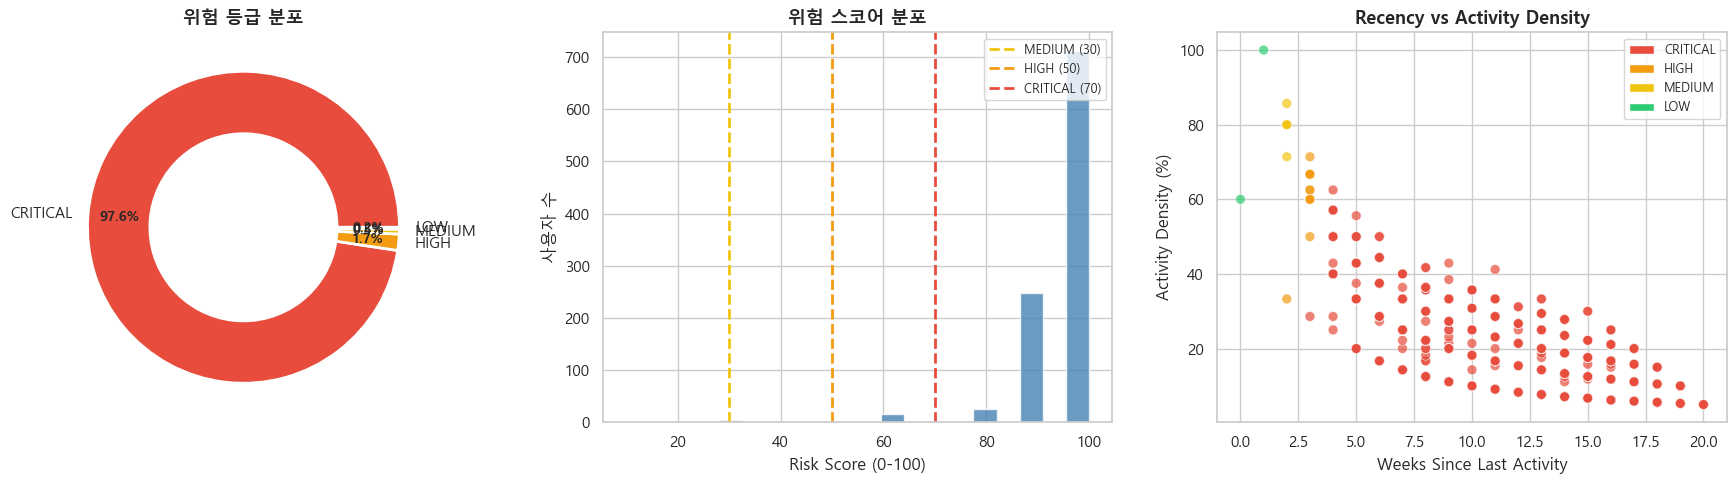

In [14]:
# 위험 등급 분포 시각화
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1) 도넛 차트 (churnVisualization.js와 동일)
level_order = ['CRITICAL', 'HIGH', 'MEDIUM', 'LOW']
level_colors = {'CRITICAL': '#e74c3c', 'HIGH': '#f39c12', 'MEDIUM': '#f1c40f', 'LOW': '#2ecc71'}
counts = [risk_dist.get(l, 0) for l in level_order]
colors = [level_colors[l] for l in level_order]

wedges, texts, autotexts = axes[0].pie(
    counts, labels=level_order, colors=colors,
    autopct='%1.1f%%', pctdistance=0.8,
    wedgeprops=dict(width=0.4, edgecolor='white', linewidth=2)
)
for t in autotexts:
    t.set_fontsize(10)
    t.set_fontweight('bold')
axes[0].set_title('위험 등급 분포', fontsize=13, fontweight='bold')

# 2) 위험 스코어 히스토그램
axes[1].hist(user_metrics['risk_score'], bins=20, color='steelblue',
             edgecolor='white', alpha=0.8)
# 등급 경계선
for threshold, label, color in [(30, 'MEDIUM', '#f1c40f'), (50, 'HIGH', '#f39c12'), (70, 'CRITICAL', '#e74c3c')]:
    axes[1].axvline(threshold, color=color, linestyle='--', linewidth=2, label=f'{label} ({threshold})')
axes[1].legend(fontsize=9)
axes[1].set_title('위험 스코어 분포', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Risk Score (0-100)')
axes[1].set_ylabel('사용자 수')

# 3) Activity Density vs Recency 산점도
color_map = user_metrics['risk_level'].map(level_colors)
axes[2].scatter(
    user_metrics['weeks_since_last'],
    user_metrics['activity_density'],
    c=color_map, alpha=0.7, edgecolors='white', linewidth=0.5, s=50
)
axes[2].set_title('Recency vs Activity Density', fontsize=13, fontweight='bold')
axes[2].set_xlabel('Weeks Since Last Activity')
axes[2].set_ylabel('Activity Density (%)')

# 범례
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=level_colors[l], label=l) for l in level_order]
axes[2].legend(handles=legend_elements, fontsize=9)

plt.tight_layout()
plt.savefig('fig_06_risk_segments.png', dpi=150, bbox_inches='tight')
plt.show()

### 3-2. 코호트별 위험 구성 비교

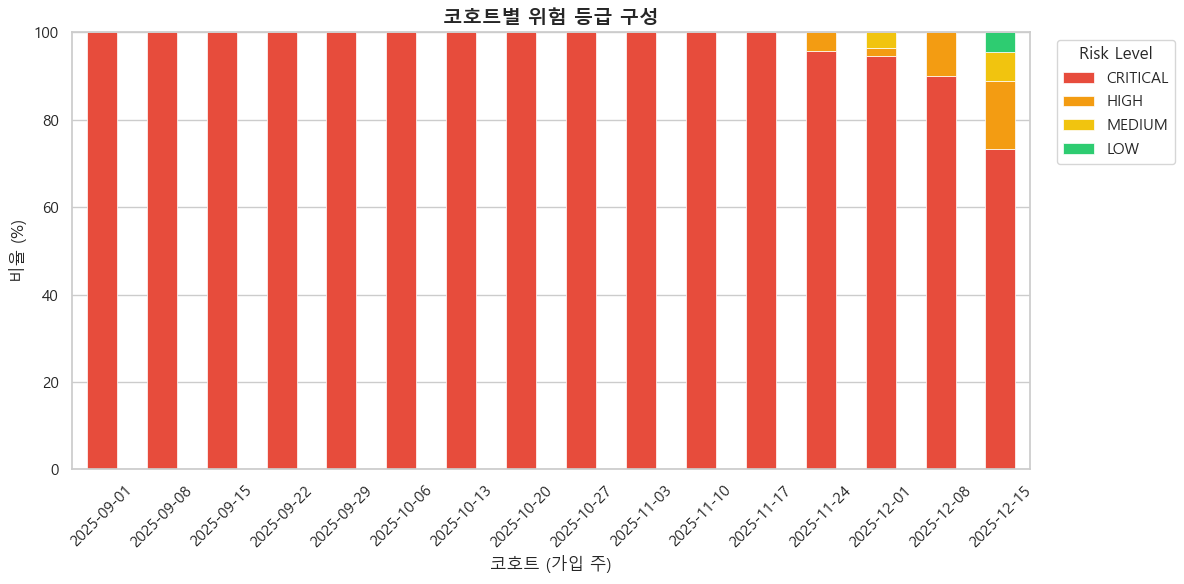

=== 코호트별 위험 등급 구성 (%) ===
risk_level   CRITICAL  HIGH  MEDIUM  LOW
cohort_week                             
2025-09-01      100.0   0.0     0.0  0.0
2025-09-08      100.0   0.0     0.0  0.0
2025-09-15      100.0   0.0     0.0  0.0
2025-09-22      100.0   0.0     0.0  0.0
2025-09-29      100.0   0.0     0.0  0.0
2025-10-06      100.0   0.0     0.0  0.0
2025-10-13      100.0   0.0     0.0  0.0
2025-10-20      100.0   0.0     0.0  0.0
2025-10-27      100.0   0.0     0.0  0.0
2025-11-03      100.0   0.0     0.0  0.0
2025-11-10      100.0   0.0     0.0  0.0
2025-11-17      100.0   0.0     0.0  0.0
2025-11-24       95.7   4.3     0.0  0.0
2025-12-01       94.5   1.8     3.6  0.0
2025-12-08       90.0  10.0     0.0  0.0
2025-12-15       73.3  15.6     6.7  4.4


In [15]:
# 코호트별 위험 등급 비율
user_cohort = df.drop_duplicates('user_id')[['user_id', 'cohort_week']]
risk_with_cohort = user_metrics.merge(user_cohort, on='user_id')

cohort_risk = pd.crosstab(
    risk_with_cohort['cohort_week'].dt.strftime('%Y-%m-%d'),
    risk_with_cohort['risk_level'],
    normalize='index'
) * 100

# 컬럼 순서 정렬
cohort_risk = cohort_risk.reindex(columns=['CRITICAL', 'HIGH', 'MEDIUM', 'LOW'], fill_value=0)

# 스택 바 차트
fig, ax = plt.subplots(figsize=(12, 6))
cohort_risk.plot(
    kind='bar', stacked=True, ax=ax,
    color=[level_colors[l] for l in cohort_risk.columns],
    edgecolor='white', linewidth=0.5
)

ax.set_title('코호트별 위험 등급 구성', fontsize=14, fontweight='bold')
ax.set_xlabel('코호트 (가입 주)')
ax.set_ylabel('비율 (%)')
ax.set_ylim(0, 100)
ax.legend(title='Risk Level', bbox_to_anchor=(1.02, 1), loc='upper left')
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('fig_07_cohort_risk_composition.png', dpi=150, bbox_inches='tight')
plt.show()

# 표 출력
print('=== 코호트별 위험 등급 구성 (%) ===')
print(cohort_risk.round(1))

---

## 4. 통계 검정

### 4-1. Chi-Square 독립성 검정

**가설**:  
- H₀: 코호트(가입 시기)와 이탈 여부는 독립이다  
- H₁: 코호트와 이탈 여부는 독립이 아니다 (가입 시기에 따라 이탈 패턴이 다르다)

**기준**: `risk_level ∈ {CRITICAL, HIGH}` → 이탈, 나머지 → 잔류  
**유의수준**: α = 0.05

In [16]:
# 이탈 여부 이진 변수
risk_with_cohort['churned'] = risk_with_cohort['risk_level'].isin(['CRITICAL', 'HIGH']).astype(int)

# 관측 빈도표
contingency = pd.crosstab(
    risk_with_cohort['cohort_week'].dt.strftime('%Y-%m-%d'),
    risk_with_cohort['churned'],
    margins=True
)
contingency.columns = ['잔류', '이탈', '합계']
contingency.index.name = '코호트'

print('=== 관측 빈도표 ===')
print(contingency)
print()

# Chi-Square 검정
observed = pd.crosstab(
    risk_with_cohort['cohort_week'].dt.strftime('%Y-%m-%d'),
    risk_with_cohort['churned']
)

chi2, p_value, dof, expected = stats.chi2_contingency(observed)

print('=== Chi-Square 독립성 검정 결과 ===')
print(f'  χ² 통계량: {chi2:.4f}')
print(f'  자유도 (df): {dof}')
print(f'  p-value: {p_value:.4f}')
print(f'  유의수준 α = 0.05')
print()

if p_value < 0.05:
    print('  ▶ 결론: H₀ 기각 → 코호트별 이탈 패턴에 유의미한 차이가 있음')
    print('    → 특정 가입 시기의 온보딩 경험에 문제가 있을 가능성')
else:
    print('  ▶ 결론: H₀ 채택 → 코호트별 이탈 패턴에 유의미한 차이 없음')
    print('    → 이탈은 가입 시기와 무관하게 전반적으로 발생')

print()
print('=== 기대 빈도표 ===')
expected_df = pd.DataFrame(
    expected,
    index=observed.index,
    columns=['잔류 (기대)', '이탈 (기대)']
)
print(expected_df.round(1))

=== 관측 빈도표 ===
            잔류    이탈    합계
코호트                       
2025-09-01   0    65    65
2025-09-08   0    70    70
2025-09-15   0    55    55
2025-09-22   0    60    60
2025-09-29   0    75    75
2025-10-06   0    68    68
2025-10-13   0    72    72
2025-10-20   0    58    58
2025-10-27   0    80    80
2025-11-03   0    62    62
2025-11-10   0    50    50
2025-11-17   0    65    65
2025-11-24   0    70    70
2025-12-01   2    53    55
2025-12-08   0    60    60
2025-12-15   5    40    45
All          7  1003  1010

=== Chi-Square 독립성 검정 결과 ===
  χ² 통계량: 84.2361
  자유도 (df): 15
  p-value: 0.0000
  유의수준 α = 0.05

  ▶ 결론: H₀ 기각 → 코호트별 이탈 패턴에 유의미한 차이가 있음
    → 특정 가입 시기의 온보딩 경험에 문제가 있을 가능성

=== 기대 빈도표 ===
             잔류 (기대)  이탈 (기대)
cohort_week                  
2025-09-01       0.5     64.5
2025-09-08       0.5     69.5
2025-09-15       0.4     54.6
2025-09-22       0.4     59.6
2025-09-29       0.5     74.5
2025-10-06       0.5     67.5
2025-10-13       0.5     71.5
2025-10-20   

### 4-2. Kaplan-Meier 생존 분석

사용자가 가입 후 **몇 주차에 이탈**하는지 생존 확률을 추정합니다.  
- **이벤트**: 마지막 활동 이후 4주 이상 미활동 → 이탈(event=1)  
- **시간**: 가입일부터 마지막 활동일까지의 주차  
- `lifelines` 패키지 활용

In [17]:
from lifelines import KaplanMeierFitter

# 생존 분석 데이터 준비
survival_data = user_metrics[['user_id', 'signup_date', 'last_event',
                               'weeks_since_last', 'tenure_weeks', 'risk_level']].copy()

# Duration: 가입일 ~ 마지막 활동일 (주)
survival_data['duration_weeks'] = (
    (survival_data['last_event'] - survival_data['signup_date']).dt.days / 7
).round(1)
# 최소 0.1주 (당일 가입+이탈)
survival_data['duration_weeks'] = survival_data['duration_weeks'].clip(lower=0.1)

# Event: 이탈 여부 (4주 이상 미활동 = 이탈)
survival_data['event_observed'] = (survival_data['weeks_since_last'] >= 4).astype(int)

print(f'전체 사용자: {len(survival_data)}')
print(f'이탈 (event=1): {survival_data["event_observed"].sum()}')
print(f'잔류 (event=0, censored): {(survival_data["event_observed"] == 0).sum()}')
print()

# Kaplan-Meier 추정
kmf = KaplanMeierFitter()
kmf.fit(
    durations=survival_data['duration_weeks'],
    event_observed=survival_data['event_observed'],
    label='전체 사용자'
)

# 생존 함수 출력
print('=== 생존 확률 (Kaplan-Meier) ===')
print(kmf.survival_function_.round(3).head(15))
print()
print(f'중앙 생존 시간: {kmf.median_survival_time_:.1f}주')

전체 사용자: 1010
이탈 (event=1): 985
잔류 (event=0, censored): 25

=== 생존 확률 (Kaplan-Meier) ===
          전체 사용자
timeline        
0.0        1.000
0.1        0.717
1.0        0.681
1.1        0.625
1.3        0.574
1.4        0.525
1.6        0.478
1.7        0.434
1.9        0.388
2.0        0.358
2.1        0.333
2.3        0.305
2.4        0.273
2.6        0.247
2.7        0.209

중앙 생존 시간: 1.6주


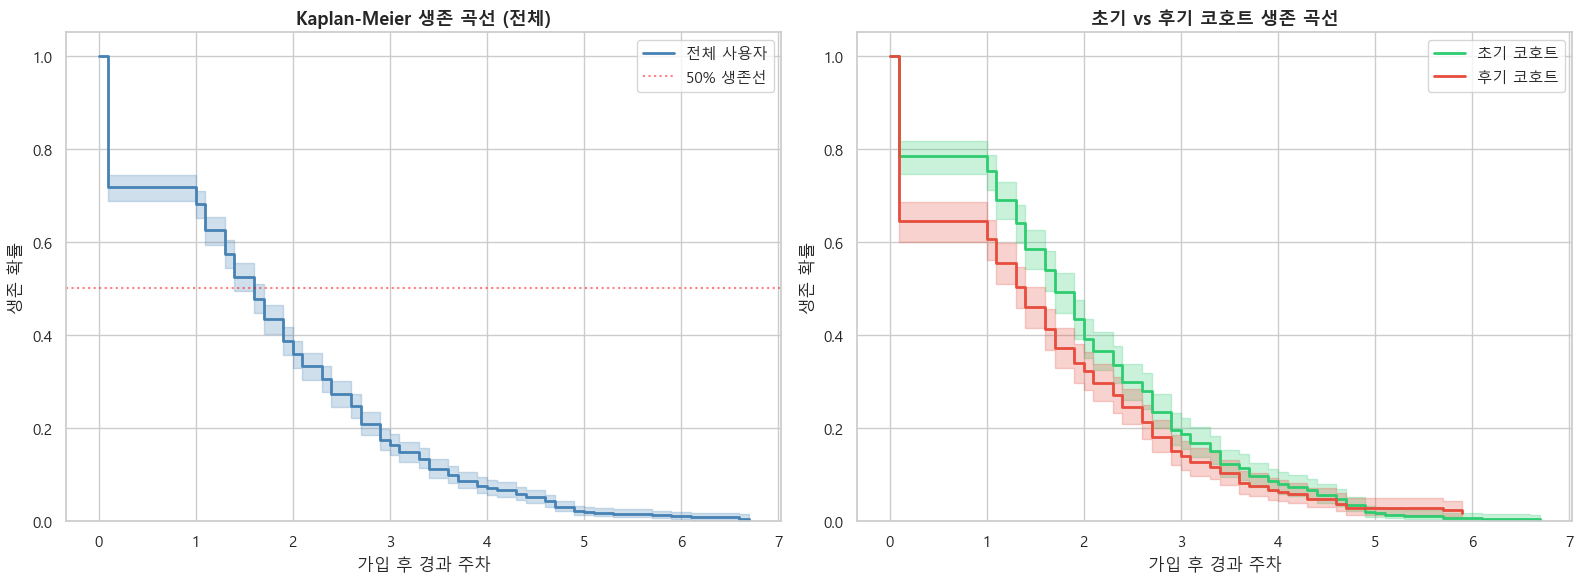

In [18]:
# Kaplan-Meier 생존 곡선 시각화
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 왼쪽: 전체 생존 곡선
kmf.plot_survival_function(ax=axes[0], ci_show=True, color='steelblue', linewidth=2)
axes[0].set_title('Kaplan-Meier 생존 곡선 (전체)', fontsize=13, fontweight='bold')
axes[0].set_xlabel('가입 후 경과 주차')
axes[0].set_ylabel('생존 확률')
axes[0].set_ylim(0, 1.05)
axes[0].axhline(0.5, color='red', linestyle=':', alpha=0.5, label='50% 생존선')
axes[0].legend()

# 오른쪽: 초기/후기 코호트 비교
cohort_dates = sorted(risk_with_cohort['cohort_week'].unique())
mid_point = len(cohort_dates) // 2
early_cohorts = set(cohort_dates[:mid_point])
late_cohorts = set(cohort_dates[mid_point:])

survival_with_cohort = survival_data.merge(
    user_cohort, on='user_id'
)

early_mask = survival_with_cohort['cohort_week'].isin(early_cohorts)
late_mask = survival_with_cohort['cohort_week'].isin(late_cohorts)

kmf_early = KaplanMeierFitter()
kmf_early.fit(
    survival_with_cohort.loc[early_mask, 'duration_weeks'],
    survival_with_cohort.loc[early_mask, 'event_observed'],
    label='초기 코호트'
)

kmf_late = KaplanMeierFitter()
kmf_late.fit(
    survival_with_cohort.loc[late_mask, 'duration_weeks'],
    survival_with_cohort.loc[late_mask, 'event_observed'],
    label='후기 코호트'
)

kmf_early.plot_survival_function(ax=axes[1], ci_show=True, color='#2ecc71', linewidth=2)
kmf_late.plot_survival_function(ax=axes[1], ci_show=True, color='#e74c3c', linewidth=2)
axes[1].set_title('초기 vs 후기 코호트 생존 곡선', fontsize=13, fontweight='bold')
axes[1].set_xlabel('가입 후 경과 주차')
axes[1].set_ylabel('생존 확률')
axes[1].set_ylim(0, 1.05)
axes[1].legend()

plt.tight_layout()
plt.savefig('fig_08_kaplan_meier.png', dpi=150, bbox_inches='tight')
plt.show()

### 4-3. Log-Rank Test (코호트 간 생존 곡선 비교)

**가설**:  
- H₀: 초기 코호트와 후기 코호트의 생존 곡선은 동일하다  
- H₁: 두 그룹의 생존 곡선에 유의미한 차이가 있다

**유의수준**: α = 0.05

In [19]:
from lifelines.statistics import logrank_test

# Log-Rank 검정: 초기 vs 후기 코호트
results = logrank_test(
    survival_with_cohort.loc[early_mask, 'duration_weeks'],
    survival_with_cohort.loc[late_mask, 'duration_weeks'],
    event_observed_A=survival_with_cohort.loc[early_mask, 'event_observed'],
    event_observed_B=survival_with_cohort.loc[late_mask, 'event_observed']
)

print('=== Log-Rank Test 결과 ===')
print(f'  검정 통계량: {results.test_statistic:.4f}')
print(f'  p-value: {results.p_value:.4f}')
print(f'  유의수준 α = 0.05')
print()

if results.p_value < 0.05:
    print('  ▶ 결론: H₀ 기각 → 초기/후기 코호트의 생존 곡선에 유의미한 차이')
    print('    → 시간에 따라 사용자 잔류 패턴이 변화하고 있음')
    print('    → 제품/마케팅 변화의 영향을 확인할 필요 있음')
else:
    print('  ▶ 결론: H₀ 채택 → 초기/후기 코호트의 생존 곡선에 유의미한 차이 없음')
    print('    → 시기와 관계없이 일관된 이탈 패턴')
    print('    → 구조적(제품 자체) 이탈 요인에 주목해야 함')

print()
print(f'초기 코호트 중앙 생존: {kmf_early.median_survival_time_:.1f}주')
print(f'후기 코호트 중앙 생존: {kmf_late.median_survival_time_:.1f}주')

=== Log-Rank Test 결과 ===
  검정 통계량: 7.3389
  p-value: 0.0067
  유의수준 α = 0.05

  ▶ 결론: H₀ 기각 → 초기/후기 코호트의 생존 곡선에 유의미한 차이
    → 시간에 따라 사용자 잔류 패턴이 변화하고 있음
    → 제품/마케팅 변화의 영향을 확인할 필요 있음

초기 코호트 중앙 생존: 1.7주
후기 코호트 중앙 생존: 1.4주


---

## 5. 비즈니스 인사이트 및 결론

### 핵심 발견 사항

In [20]:
# 종합 인사이트 대시보드
print('=' * 60)
print('        CohortIQ 분석 종합 인사이트')
print('=' * 60)
print()

# 1. 리텐션 요약
avg_ret = retention_matrix.mean()
w1 = avg_ret.get(1, float('nan'))
w4 = avg_ret.get(4, float('nan'))
print(f'[리텐션]')
print(f'  Week 1 평균 리텐션: {w1:.1f}%')
if not np.isnan(w4):
    print(f'  Week 4 평균 리텐션: {w4:.1f}%')
    drop = w1 - w4
    print(f'  Week 1→4 리텐션 하락: {drop:.1f}%p')
print()

# 2. Churn 위험 요약
critical = risk_dist.get('CRITICAL', 0)
high = risk_dist.get('HIGH', 0)
at_risk = critical + high
at_risk_pct = at_risk / len(user_metrics) * 100
print(f'[Churn 위험]')
print(f'  고위험 (CRITICAL+HIGH): {at_risk}명 ({at_risk_pct:.1f}%)')
print(f'  평균 위험 스코어: {user_metrics["risk_score"].mean():.1f}/100')
print()

# 3. 통계 검정 요약
print(f'[통계 검정]')
print(f'  Chi-Square (코호트×이탈 독립성): p={p_value:.4f}',
      '→ 유의' if p_value < 0.05 else '→ 비유의')
print(f'  Log-Rank (초기 vs 후기 생존): p={results.p_value:.4f}',
      '→ 유의' if results.p_value < 0.05 else '→ 비유의')
print(f'  중앙 생존 시간: {kmf.median_survival_time_:.1f}주')
print()

# 4. 실행 권장 사항
print(f'[실행 권장 사항]')
print(f'  1. 가입 후 첫 1주 온보딩 강화 (Week 1 리텐션이 핵심 지표)')
print(f'  2. CRITICAL 사용자 {critical}명 대상 재참여 캠페인 즉시 실행')
print(f'  3. 가장 위험한 코호트 집중 분석 → 해당 시기 이벤트/변경사항 확인')
if not np.isnan(w4) and w4 < 30:
    print(f'  4. Week 4 리텐션 {w4:.0f}% → 업계 기준(25-35%) 대비 추가 조치 필요')
print()
print('=' * 60)
print('  분석 도구: CohortIQ (https://cohort-iq.vercel.app)')
print('  방법론: docs/METHODOLOGY.md 참조')
print('=' * 60)

        CohortIQ 분석 종합 인사이트

[리텐션]
  Week 1 평균 리텐션: 69.9%
  Week 4 평균 리텐션: 5.7%
  Week 1→4 리텐션 하락: 64.2%p

[Churn 위험]
  고위험 (CRITICAL+HIGH): 1003명 (99.3%)
  평균 위험 스코어: 95.8/100

[통계 검정]
  Chi-Square (코호트×이탈 독립성): p=0.0000 → 유의
  Log-Rank (초기 vs 후기 생존): p=0.0067 → 유의
  중앙 생존 시간: 1.6주

[실행 권장 사항]
  1. 가입 후 첫 1주 온보딩 강화 (Week 1 리텐션이 핵심 지표)
  2. CRITICAL 사용자 986명 대상 재참여 캠페인 즉시 실행
  3. 가장 위험한 코호트 집중 분석 → 해당 시기 이벤트/변경사항 확인
  4. Week 4 리텐션 6% → 업계 기준(25-35%) 대비 추가 조치 필요

  분석 도구: CohortIQ (https://cohort-iq.vercel.app)
  방법론: docs/METHODOLOGY.md 참조
